# Image region-level saliency using VGG-19 Conv-net

Lets have plots appear inline:

In [1]:
%matplotlib inline

We're going to need `numpy`, `matplotlib`, `skimage`, `theano` and `lasagne`. The `pretrained_vgg_models` contains some useful functions for building and acquiring VGG models.

In [2]:
import os, time
import numpy as np
from matplotlib import pyplot as plt
import theano
import lasagne
import skimage.transform, skimage.util
import pretrained_vgg_models

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer, DropoutLayer, Pool2DLayer, Conv2DLayer, NINLayer
from lasagne.nonlinearities import softmax
from lasagne.utils import floatX


/Users/Geoff/packages/Theano/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


## Load an image to process

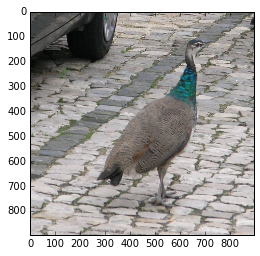

In [3]:
IMAGE_PATH = os.path.join('images', 'P1013781.JPG')
# Extract a 896 x 896 block surrounding the peacock
img = plt.imread(IMAGE_PATH)[1800:2696,652:1548]
plt.imshow(img)
plt.show()

## Load the model

To save some time, we are going to use the `VGG19Model` class from `pretrained_vgg_models` to build the network and load its parameters:

In [4]:
vgg19_model = pretrained_vgg_models.VGG19Model.load()

Create the input variable, generate the probability expression and construct a Theano function that we can call:

In [5]:
in_var = theano.tensor.tensor4('x')
prob = lasagne.layers.get_output(vgg19_model.network['prob'], in_var, deterministic=True)
prob_fn = theano.function([in_var], prob)

Prepare the image, scaling to 224x224:

In [6]:
raw_img, img_for_vgg = vgg19_model.prepare_image(img, image_size=224)

## Discover the salient regions of the image - simple method
The simplest method to determine if part of an image is *salient* is to mask it out and evaluate the effect on the predicted class probability. The idea was briefly described by Felix Lau in http://felixlaumon.github.io/2015/01/08/kaggle-right-whale.html. The approach that we will use is a little different; while Lau slid a black box over the image we will slide a box of value 0.0 over the image, where the pixel values already have 0-mean, so the actual box colour will be an off-grey.

This approach to image saliency uses the existing unmodified network. We will generate a set of images, each one with a different part masked out. We generate these images by sliding the mask over the image in both the vertical and horizontal axes and generating a new image for each position. We then use the network to generate a prediction for each masked image and use the output to determine saliency.

In [7]:
MASK_SHAPE = 64,64
STEP_SHAPE = 16,16

n_y = 0
masked_images = []
for i in xrange(0, img_for_vgg.shape[2] - MASK_SHAPE[0] + 1, STEP_SHAPE[0]):
    for j in xrange(0, img_for_vgg.shape[3] - MASK_SHAPE[1] + 1, STEP_SHAPE[1]):
        # Take a copy of the image
        masked_img = img_for_vgg.copy()
        # Set the masked region to 0
        masked_img[:,:,i:i+MASK_SHAPE[0], j:j+MASK_SHAPE[1]] = 0.0
        masked_images.append(masked_img)
    n_y += 1

masked_images = np.concatenate(masked_images, axis=0)
pred_shape = n_y, masked_images.shape[0] / n_y
print masked_images.shape, pred_shape

(121, 3, 224, 224) (11, 11)


Lets take a look at a few of the masked images:

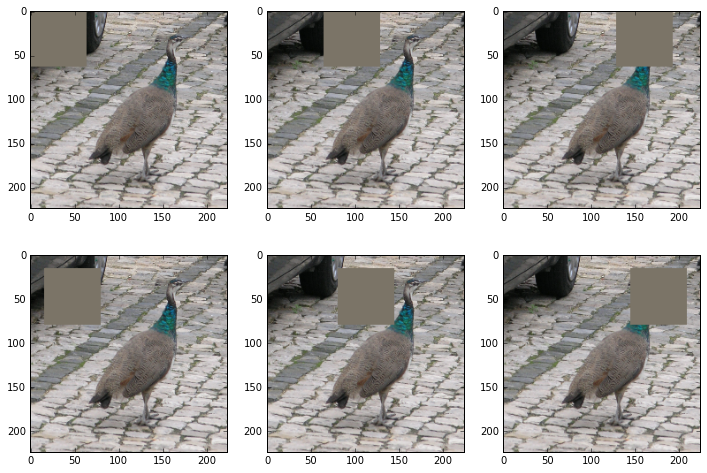

In [8]:
plt.figure(figsize=(12,8))
for i in xrange(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(vgg19_model.inv_prepare_image(masked_images[i*4]))
plt.show()

### Predict probabilities for the unmasked image and the masked images

The original unmasked image:

In [9]:
# First, generate a prediction for the unmasked image:
pred_prob_unmasked = prob_fn(img_for_vgg)
# Get the predicted probability of the unmasked image being a peacock:
unmasked_peacock_prob = pred_prob_unmasked[0,84]
print('Unmasked image: probability of peacock {:.3f}'.format(unmasked_peacock_prob))

Unmasked image: probability of peacock 0.990


Generate predictions for the masked images in batches of 16:

In [10]:
t1 = time.time()
pred_prob_masked_flat = [prob_fn(masked_images[i:i+16,:,:,:]) for i in xrange(0, masked_images.shape[0], 16)]
t2 = time.time()
pred_prob_masked_flat = np.concatenate(pred_prob_masked_flat, axis=0)

print('Prediction for {} images took {:.2f}s, resulting in an array of shape{}'.format(masked_images.shape[0],
                                                                                       t2-t1, pred_prob_masked_flat.shape))

Prediction for 121 images took 63.48s, resulting in an array of shape(121, 1000)


So we can visualise the predictions, lets reshape the predictions back into two dimensions. The variable `pred_shape` contains the 2D shape of the predicted output:

In [11]:
pred_prob_masked_2d = pred_prob_masked_flat.reshape(pred_shape + (1000,))
print('Predicted probability 2D shape {}, p(peacock) min {:.3f} max {:.3f}'.format(
        pred_prob_masked_2d.shape, pred_prob_masked_2d[:,:,84].min(), pred_prob_masked_2d[:,:,84].max()))

Predicted probability 2D shape (11, 11, 1000), p(peacock) min 0.044 max 0.995


### Generate saliency image

Generate a saliency image by computing the change in probabilty caused by masking.

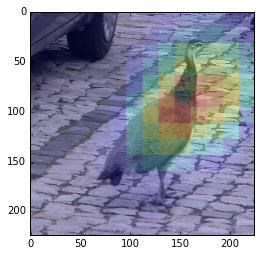

In [13]:
# Saliency image, same size as original
d_prob_2d = np.zeros(img_for_vgg.shape[2:])
# Saliency coverage since we will be averaging
saliency_coverage_2d = np.zeros(img_for_vgg.shape[2:])
for i in xrange(pred_prob_masked_2d.shape[0]):
    y = i * STEP_SHAPE[0]
    for j in xrange(pred_prob_masked_2d.shape[1]):
        x = j * STEP_SHAPE[1]
        # Compute the difference in probability
        d_prob = unmasked_peacock_prob - pred_prob_masked_2d[i,j,84]
        # Accumulate in the saliency image
        d_prob_2d[y:y+MASK_SHAPE[0], x:x+MASK_SHAPE[1]] += d_prob
        # Accumulate saliency coverage
        saliency_coverage_2d[y:y+MASK_SHAPE[0], x:x+MASK_SHAPE[1]] += 1.0
# Compute average probability change (clip saliency_coverage_2d to >= 1.0)
saliency_2d = d_prob_2d / np.maximum(saliency_coverage_2d, 1.0)
plt.imshow(raw_img)
plt.imshow(saliency_2d, alpha=0.25)
plt.show()